# EfficientNetB4 for Cassava Leaf Disease Classification Dataset with Fastai

Cassava is the second largest provider of carbohydrates in the continent of Africa and is key to growth of small farmers because it can withstand harsh conditions. A major percentage of farmers rely on growing this crop but its vulnerability to viral diseases is a major impediment for growth. Image recognition is a fast and inexpensive means of screening the crops for any present viral disease and can offer means to mitigate the spread of the disease by take effective and immediate remedial actions. Transfer learning has proven to be one of the most effective methods in various fields of computer vision in recent times. In this kernel we fine tune an EfficientNet based model to achieve fair results on the Cassava Leaf Disease Classification Dataset. The program is written in fastai.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Now we will need to import all the necessary libraries with some additional functionality. The code below will import all of the libraries necessary to run the code.

In [2]:
import numpy as np
import pandas as pd
import os
from fastai.vision import *
from fastai.vision.all import *
from fastai.callback import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

With the rise of transfer learning, the essentiality of scaling has been deeply realised for enhancing the performance as well as efficieny of models. Traditionaly scaling can be done in three dimensions viz. depth, width and resolution in terms of convolutional neural networks. Depth scaling pertains to increasing the number of layers in the model, making it more deeper; width scaling makes the model wider (one possible way is to increase the number of channels in a layer) and resolution scaling means using high resolution images so that features are more fine-grained. Each method applied individually has some drawbacks such as in depth scaling we have the problem of vanishing gradients and in width scaling the accuracy saturates after a point and there is a limit to increasing resolution of images and a slight increase doesnt result in significant improvement of performance. Hence Efficientnets are proposed to deal with balancing all dimensions of a network during CNN scaling for getting improved accuracy and efficieny. The authors proposed a simple yet very effective scaling technique which uses a compound coefficientto uniformly scale network width, depth, and resolution in a principled way. We used the pytorch wrapper for efficientnets. To install run the following command:  

In [4]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=43c4b3a107e971cc2792bb9ae0ab06b8dc043ac436e16b0735476a0b8fc45312
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


In [5]:
import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [6]:
data_root = Path('../input/cassava-leaf-disease-classification')
os.listdir(data_root)

['sample_submission.csv',
 'train_images',
 'test_tfrecords',
 'train_tfrecords',
 'label_num_to_disease_map.json',
 'test_images',
 'train.csv']

In [7]:
train = pd.read_csv(data_root / 'train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Since Fastai dataloaders need to know the entire filepath of an image from a dataframe, we have to replace the image_id i.e name of the image in the train dataframe to the entire path of the image. Images for training are kept in the train_images folder and the public test images are kept in the test_images folder.

In [8]:
train['img_path'] = train['image_id'].map(lambda x : data_root/'train_images'/x)
train = train.drop(columns = ['image_id'])
train.head()

,label,img_path
0,0,../input/cassava-leaf-disease-classification/train_images/1000015157.jpg
1,3,../input/cassava-leaf-disease-classification/train_images/1000201771.jpg
2,1,../input/cassava-leaf-disease-classification/train_images/100042118.jpg
3,1,../input/cassava-leaf-disease-classification/train_images/1000723321.jpg
4,3,../input/cassava-leaf-disease-classification/train_images/1000812911.jpg


Now we visualize a sample Image from the training set.

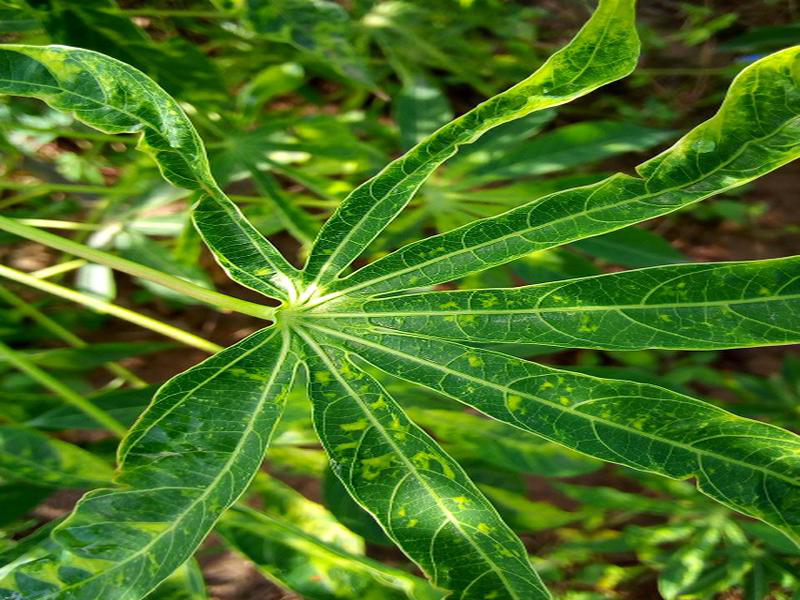

In [9]:
from PIL import Image
img = Image.open(train['img_path'][44])
img

Now we come to perform some data augmentation on our images for better prediction. The item_tfms picks a random scaled crop of an image and resizes it to the size mentioned. Next we perform batch transformations that performs a series of augmentations such as resizing the images to 224X224, flipping, rotating, zooming and affine transformations.

In [10]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

Here we load the data from our training dataframe using the ImageDataLoader class which is the highest level of API for loading data. We pass all the required parameters into the dataloader.

In [11]:
data = ImageDataLoaders.from_df(train, 
                               valid_pct=0.2, 
                               seed=999, 
                               label_col=0, 
                               fn_col=1, 
                               bs=32, 
                               item_tfms=item_tfms,
                               batch_tfms=batch_tfms) 

In [12]:
data.train_ds

(#17118) [(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(4)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(0)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(1)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(0))...]

In [13]:
data.valid_ds

(#4279) [(PILImage mode=RGB size=800x600, TensorCategory(2)),(PILImage mode=RGB size=800x600, TensorCategory(2)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(1)),(PILImage mode=RGB size=800x600, TensorCategory(4)),(PILImage mode=RGB size=800x600, TensorCategory(2)),(PILImage mode=RGB size=800x600, TensorCategory(0)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3)),(PILImage mode=RGB size=800x600, TensorCategory(3))...]

In [14]:
data.c

5

Here we can visualize a batch of images with their related labels pertaining to the type of disease.

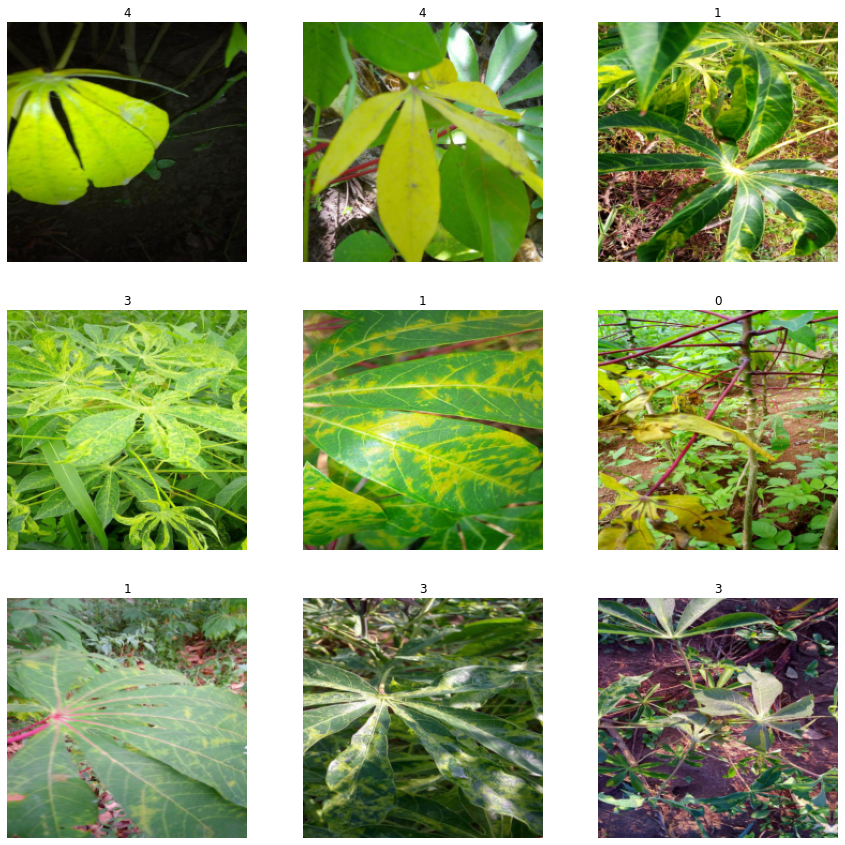

In [15]:
data.show_batch(figsize = (15,15))

Lets train a simple efficientnet-b4 model.

In [16]:
model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


Before we train our model lets define a metric that gives additional perpective regarding its performance. We define the Top 3 accuracy metric which tells us the measure of how often our predicted class falls in the top 3 values of our softmax distribution. In this case we have 5 classes, each with a respective softmax distribution. Top3 accuracy is calculated by the number of the images whose labels fall in the top 3 classes of the predicted softmax distribution out of all the predictions made.

In [17]:
top3 = partial(top_k_accuracy, k=3)

Now we define the prebuilt learner class which lets us use transfer learning models rapidly without much hassle. For the loss function we have used SOTA label smoothing crossentropy which shows promising results in image classification. We can also used mixed precision easily. 

In [18]:
learn = Learner(data, model, metrics=[accuracy, top3], loss_func=LabelSmoothingCrossEntropy()).to_fp16()

 In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0014454397605732083)

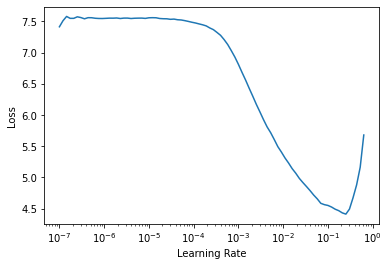

In [19]:
learn.unfreeze()
learn.lr_find()


As show above the optimal learning rate to be used with out model should be just before the loss takes a steep dip. Here we settle with 1e-2 for the learning rate. 

In [20]:
learn.fine_tune(10,base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.776684,6.929300,0.395419,0.515307,06:49


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.508496,1.515002,0.819117,0.965412,06:33
1,1.526023,1.629592,0.771208,0.952559,06:30
2,1.507683,1.867913,0.741295,0.940874,06:37
3,1.496514,4.045783,0.301239,0.888292,06:42
4,1.498794,1.673173,0.753447,0.940173,06:46
5,1.407032,1.510584,0.819584,0.968918,06:49
6,1.376257,1.414135,0.857443,0.979668,06:50
7,1.358680,1.382066,0.861416,0.980136,06:47
8,1.322549,1.363431,0.869596,0.982239,06:46
9,1.304314,1.364084,0.869829,0.982473,06:43


* Voila! With just a few lines, we applied SOTA techniques to achieve a good accuracy and top3accuracy. Thats not bad.

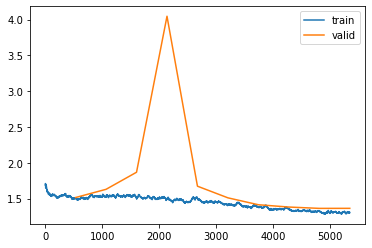

In [21]:
learn.recorder.plot_loss()

Fastai provides an easy functionality to plot the confusion matrix. This matrix gives an indication of actually predicted classes and the classes which belong to one class but have been misclassified as another. The diagonal pertains to all the images that have been rightly classified.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

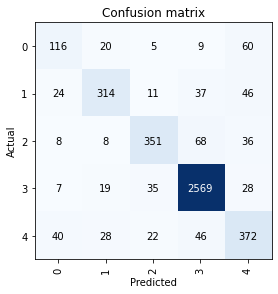

In [24]:
interp.plot_confusion_matrix()

Now we will make our submissions

In [25]:
sample_df = pd.read_csv(data_root/'sample_submission.csv')
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [26]:
sample_df1 = sample_df.copy()
sample_df1['img_path'] = sample_df1['image_id'].map(lambda x:data_root/'test_images'/x)
sample_df1 = sample_df1.drop(columns=['image_id'])
test_dl = data.test_dl(sample_df1)

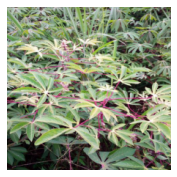

In [27]:
test_dl.show_batch()

Now lets get the predictions. We will use the common technique known as the Test time Augmentation prebuilt to get predictions. 

In [28]:
preds, _ = learn.tta(dl=test_dl, beta=0)

In [29]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [30]:
cd '/kaggle/working'

/kaggle/working


In [31]:
sample_df.to_csv('submission.csv',index=False)

And we are done!

Please give an upvote if you learned something from this kernel. Thank you. Have a nice day!